# Time Series Models

In [3]:
from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import itertools
#from pmdarima import auto_arima

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import os, sys
path_add = os.path.abspath(os.pardir)
if path_add not in sys.path:
    sys.path.append(path_add)

%matplotlib inline

## Agenda

SWBAT:

- explain auto-regressive and moving-average models;
- explain the notions of autocorrelation and partial autocorrelation;
- use `statsmodels` to build ARMA, ARIMA, SARIMA, and SARIMAX models.

If we think back to our lecture on the bias-variance tradeoff, a perfect model is not possible. There will always be noise (inexplicable error). A timeseries that is completely random is called white noise, and is written mathematically as:

$$\Large Y_t =  \epsilon_t$$

The error term is randomly distributed around the mean, has constant variance, and no autocorrelation.

In [4]:
# Let's make some white noise!

rands = []
for _ in range(1000):
    rands.append(gs(0, 1))
series = pd.Series(rands)

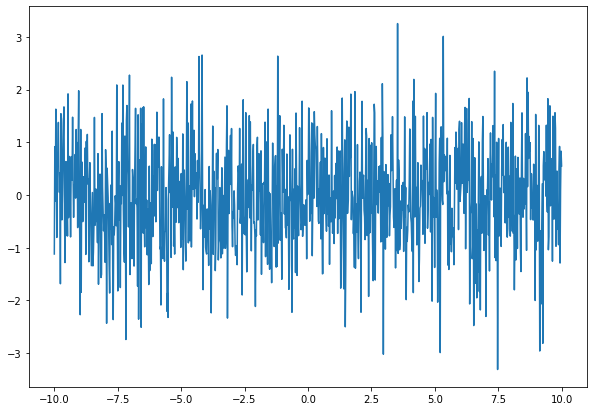

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))

X = np.linspace(-10, 10, 1000)
ax.plot(X, series);

We know this data has no true pattern governing its fluctuations (because we coded it with a random function).

Any attempt at a model would be fruitless.  The next point in the series could be any value, completely independent of the previous value.

We will assume that the timeseries data that we are working with is more than just white noise.

## Chicago Gun Data

Let's reimport our chicago gun crime data, and prepare it in the same manner as the last notebook.


In [6]:
ts = pd.read_csv('../data/Gun_Crimes_Heat_Map.csv')
ts['Date'] = pd.to_datetime(ts.Date)
ts_minute = ts.groupby('Date').count()['ID']
daily_count = ts_minute.resample('D').sum()
daily_count = daily_count[daily_count < 90]

ts_dr = pd.date_range(daily_count.index[0], daily_count.index[-1])
ts_daily = np.empty(shape=len(ts_dr))
ts_daily = pd.Series(ts_daily)
ts_daily = ts_daily.reindex(ts_dr)
ts_daily = ts_daily.fillna(daily_count)
ts_daily = ts_daily.interpolate()

ts_weekly = ts_daily.resample('W').mean()

FileNotFoundError: [Errno 2] No such file or directory: '../data/Gun_Crimes_Heat_Map.csv'

In [ ]:
ts_weekly

In [ ]:
fig, ax = plt.subplots()
ax.plot(ts_weekly)
ax.set_title("Weekly Reports of Gun Offenses in Chicago");

The train-test split for a time series is a little different from what we are used to. Because **chronological order matters**, we cannot randomly sample points in our data. Instead, we cut off a portion of our data at the end, and reserve it as our test set.

In [ ]:
# find the index which allows us to split off 20% of the data
cutoff = round(ts_weekly.shape[0]*0.8)
cutoff

In [ ]:
# Define train and test sets according to the index found above
train = ts_weekly[:cutoff]
test = ts_weekly[cutoff:]

fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.set_title('Train test Split');

We will now set aside our test set, and build our model on the train.

## Random Walk

A good first attempt at a model for a time series would be to simply predict the next data point with the point previous to it.  

We call this type of time series a random walk, and it is written mathematically like so.

$$\Large Y_t = Y_{t-1} + \epsilon_t$$

$\epsilon$ represents white noise error.  The formula indicates that the difference between a point and a point before it is white noise.

$$\Large Y_t - Y_{t-1}=  \epsilon_t$$

This makes sense, given one way we described making our series stationary was by applying a difference of a lag of 1.

Let's bring back our Chicago gun crime data and make a simple random walk model.

In [ ]:
train

In [ ]:
# we can perform this with the shift operator
# The prediction for the next day is the original series shifted to the future by one day.
random_walk = train.shift(1)
random_walk

In [ ]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
random_walk[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('Random Walk')
ax.legend();

For a baseline to compare our later models, lets calculate our **RMSE** for the random walk

In [ ]:
np.sqrt(mean_squared_error(train[1:], random_walk.dropna()))

In [ ]:
residuals = random_walk[1:] - train[1:]
mse = (residuals**2).sum()/len(residuals-1)
np.sqrt(mse)

Now, let's plot the residuals.

In [ ]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

In [ ]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

If we look at the rolling standard deviation of our errors, we can see that the performance of our model varies at different points in time.

That is a result of the trends in our data.

In the previous notebook, we were able to make our series **stationary** by differencing our data.

Visually, our differenced data looks *more* like white noise:

In [ ]:
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Weekly differenced data');

By removing the trend from our data, we assume that our data's mean and variance are constant throughout.  But it is **not** just white noise.  If it were, our models could do no better than random predictions around the mean.  

Our task now is to find **more patterns** in the series.  

We will focus on the data points near to the point in question.  We can attempt to find patterns to how much influence previous points in the sequence have. 

If that made you think of regression, great! What we will be doing is assigning weights, like our betas, to previous points.

## The Autoregressive Model (AR)

Our next attempt at a model is the autoregressive model, which is a timeseries regressed on its previous values.

### $y_{t} = \phi_{0} + \phi_{1}y_{t-1} + \varepsilon_{t}$

The above formula is a first order autoregressive model (AR1), which finds the best weight $\phi$ which, when multiplied by the point previous to a point in question, yields the best-
fit model. 

### `statsmodels.tsa.arima_model.ARIMA`

This model is really a compound of two simpler models. This ARIMA class takes a triple of values as its "order". We'll explain this shortly, but for now just note that the first member of the triple, i.e. the **p** variable of the order (p, d, q), represents the AR term. So for a first-order AR model, we'll put a 1 there.

The 1 in the second place of the order will do our differencing for us.

In [2]:
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

NameError: name 'train' is not defined

The ARIMA class comes with a nice summary table.  

In [19]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  298
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -873.148
Date:                Tue, 13 Apr 2021   AIC                           1750.296
Time:                        02:26:05   BIC                           1757.683
Sample:                    01-05-2014   HQIC                          1753.253
                         - 09-15-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2883      0.056     -5.184      0.000      -0.397      -0.179
sigma2        20.9389      1.554     13.478      0.000      17.894      23.984
===================================================================================
Ljung-Box (Q):                       91.62   Jarque-Bera (JB):                 5.01
Prob(Q):                              0.00   Prob(JB):                         0.08
Heteroskedasticity (H):               1.42   Skew:                             0.23
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
ar_1.aic

1750.295516508565

But, as you may notice, the output does not include RMSE.

It does include [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion). A better model has a lower AIC.

Let's compare the first order autoregressive model to our Random Walk.

In [21]:
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit()
random_walk_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  298
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -885.703
Date:                Tue, 13 Apr 2021   AIC                           1773.407
Time:                        02:26:05   BIC                           1777.100
Sample:                    01-05-2014   HQIC                          1774.885
                         - 09-15-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        22.7930      1.677     13.589      0.000      19.506      26.080
===================================================================================
Ljung-Box (Q):                      121.51   Jarque-Bera (JB):                 3.70
Prob(Q):                              0.00   Prob(JB):                         0.16
Heteroskedasticity (H):               1.61   Skew:                             0.13
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
print(f'Random Walk AIC: {random_walk_model.aic}')
print(f'AR(1, 1, 0) AIC: {ar_1.aic}' )

Random Walk AIC: 1773.4067346708443
AR(1, 1, 0) AIC: 1750.295516508565


Our AIC for the AR(1) model is lower than the random walk, indicating improvement.  

Let's also check the RMSE.

In [23]:
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

4.916994704726451

In [24]:
y_hat_rw = random_walk_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_rw))

5.097365380006156

RMSE is lower as well.

Autoregression, as we said before, is a regression of a time series on lagged values of itself.  

From the summary, we see the coefficient of the 1st lag:

In [25]:
ar_1.arparams

array([-0.28833721])

We come close to reproducing this coefficient with linear regression, with slight differences due to how statsmodels performs the regression. 

In [26]:
lr = LinearRegression()
lr.fit(np.array(train.diff().shift(1).dropna()).reshape(-1,1), train[1:].diff().dropna())
print(lr.coef_)

[-0.28299508]


In [27]:
train.diff()

2014-01-05          NaN
2014-01-12   -12.200000
2014-01-19     5.571429
2014-01-26     0.000000
2014-02-02    -2.285714
                ...    
2019-08-18    -7.714286
2019-08-25    -2.857143
2019-09-01     0.000000
2019-09-08    -4.142857
2019-09-15     6.571429
Freq: W-SUN, Length: 298, dtype: float64

In [28]:
train[1:].diff()

2014-01-12         NaN
2014-01-19    5.571429
2014-01-26    0.000000
2014-02-02   -2.285714
2014-02-09   -5.142857
                ...   
2019-08-18   -7.714286
2019-08-25   -2.857143
2019-09-01    0.000000
2019-09-08   -4.142857
2019-09-15    6.571429
Freq: W-SUN, Length: 297, dtype: float64

In [29]:
lr.fit(np.array(train.diff().shift(1).dropna()).reshape(-1,1), train[1:].diff().dropna())

LinearRegression()

We can also factor in more than just the most recent point.
$$\large y_{t} = \phi_{0} + \phi_{1}y_{t-1} + \phi_{2}y_{t-2}+ \varepsilon_{t}$$

We refer to the order of our AR model by the number of lags back we go.  The above formula refers to an **AR(2)** model. We put a 2 in the p position of the ARIMA class order.

In [30]:
ar_2 = ARIMA(train, order=(2, 1, 0)).fit()

ar_2.predict(typ='levels')

2014-01-05     0.000000
2014-01-12    31.199797
2014-01-19    22.481150
2014-01-26    26.323162
2014-02-02    22.816761
                ...    
2019-08-18    48.518157
2019-08-25    44.896898
2019-09-01    43.501611
2019-09-08    40.899830
2019-09-15    37.411646
Freq: W-SUN, Length: 298, dtype: float64

In [31]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)

1773.4067346708443
1750.295516508565
1722.0181960794707


Our AIC improves with more lagged terms.

## Moving Average Model (MA)

The next type of model is based on error.  The idea behind the moving average model is to make a prediction based on how far off we were the day before.

$$\large Y_t = \mu +\epsilon_t + \theta\epsilon_{t-1}$$

The moving average model works like this. We make a prediction, see how far off we were, then adjust our next prediction by a factor of how far off our pervious prediction was.

In our ARIMA model, the q term of our order (p, d, q) refers to the MA component. To use one lagged error, we put 1 in the q position.

In [32]:
ma_1 = ARIMA(train, order=(0, 0, 1)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat

2014-01-05    35.658933
2014-01-12    33.580932
2014-01-19    26.978507
2014-01-26    34.106432
2014-02-02    29.305679
                ...    
2019-08-18    40.795779
2019-08-25    37.069285
2019-09-01    37.664081
2019-09-08    37.257131
2019-09-15    34.701084
Freq: W-SUN, Length: 298, dtype: float64

In [33]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  298
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -936.689
Date:                Tue, 13 Apr 2021   AIC                           1879.379
Time:                        02:26:06   BIC                           1890.470
Sample:                    01-05-2014   HQIC                          1883.819
                         - 09-15-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.6589      0.560     63.726      0.000      34.562      36.756
ma.L1          0.6842      0.045     15.182      0.000       0.596       0.773
sigma2        31.3906      2.702     11.620      0.000      26.096      36.685
===================================================================================
Ljung-Box (Q):                      690.96   Jarque-Bera (JB):                 1.50
Prob(Q):                              0.00   Prob(JB):                         0.47
Heteroskedasticity (H):               0.84   Skew:                             0.15
Prob(H) (two-sided):                  0.39   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Let's look at the 1st order MA model with a 1st order difference

In [34]:
ma_1 = ARIMA(train, order=(0, 1, 1)).fit()

print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)

1773.4067346708443
1750.295516508565
1722.0181960794707
1724.1691361581486


It performs better than a 1st-order AR, but worse than a 2nd-order AR model.

Just like our AR models, we can lag back as far as we want. Our MA(2) model would use the past two lagged terms:

$$\large Y_t = \mu +\epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2}$$

and our MA term would be two.

In [35]:
ma_2 = ARIMA(train, order=(0, 1, 2)).fit()
y_hat = ma_2.predict(typ='levels')
y_hat

2014-01-05     0.000000
2014-01-12    31.199814
2014-01-19    22.258189
2014-01-26    25.849647
2014-02-02    24.629101
                ...    
2019-08-18    48.131076
2019-08-25    44.144699
2019-09-01    42.741324
2019-09-08    41.946282
2019-09-15    38.868989
Freq: W-SUN, Length: 298, dtype: float64

In [36]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)

1773.4067346708443
1750.295516508565
1722.0181960794707
1724.1691361581486
1716.9613487649344


## ARMA

We don't have to limit ourselves to just AR or MA.  We can use both AR terms and MA terms.

for example, an ARMA(2, 2) model is given by:

 $$\large Y_t = \mu+\phi_1 Y_{t-1}+\phi_2 Y_{t-2}+\theta_1\epsilon_{t-1}+\theta_2\epsilon_{t-2}+\epsilon_t$$

In [37]:
arma_21 = ARIMA(train, order=(2, 1, 2)).fit()

In [38]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)
print(arma_21.aic)

1773.4067346708443
1750.295516508565
1722.0181960794707
1724.1691361581486
1716.9613487649344
1715.97712451696


Best performance so far.

## ACF and PACF

We have been able to reduce our AIC by chance, adding fairly random p, d, and q terms.

But we have tools to help guide us in these decisions: the autocorrelation and partial autocorrelation functions.

### PACF

In general, a partial correlation is a **conditional correlation**. It is the  amount of correlation between a variable and a lag of itself that is not explained by correlations at all lower-order-lags. If $Y_t$ is correlated with $Y_{t-1}$, and $Y_{t-1}$ is equally correlated with $Y_{t-2}$, then we should also expect to find correlation between $Y_t$ and $Y_{t-2}$. Thus, the correlation at lag 1 "propagates" to lag 2 and presumably to higher-order lags. The partial autocorrelation at lag 2 is therefore the difference between the actual correlation at lag 2 and the expected correlation due to the propagation of correlation at lag 1.

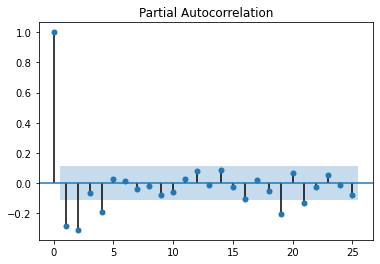

In [39]:
plot_pacf(train.diff().dropna());

The shaded area of the graph is the confidence interval. When the correlation drops into the shaded area, that means there is no longer statistically significant correlation between lags.

For an AR process, we run a linear regression on lags according to the order of the AR process. The coefficients calculated factor in the influence of the other variables.   

Since the PACF shows the direct effect of previous lags, it helps us choose AR terms.  If there is a significant positive value at a lag, consider adding an AR term according to the number that you see.

Some rules of thumb: 

    - A sharp drop after lag "k" suggests an AR-k model.
    - A gradual decline suggests an MA.

## ACF

The autocorrelation plot of our time series is simply a version of the correlation plots we used in linear regression.  Our features this time are prior points in the time series, or the **lags**. 

We can calculate a specific covariance ($\gamma_k$) with:

${\displaystyle \gamma_k = \frac 1 n \sum\limits_{t=1}^{n-k} (y_t - \bar{y_t})(y_{t+k}-\bar{y_{t+k}})}$

In [40]:
df = pd.DataFrame(train)
df.columns = ['lag_0']
df['lag_1'] = train.shift()
df.head()

,lag_0,lag_1
2014-01-05,31.200000,NaN
2014-01-12,19.000000,31.200000
2014-01-19,24.571429,19.000000
2014-01-26,24.571429,24.571429
2014-02-02,22.285714,24.571429


In [41]:
gamma_1 = sum(((df['lag_0'][1:]-df['lag_0'][1:].mean()) *\
               (df['lag_1'].dropna()-df['lag_1'].dropna().mean())))/(len(df['lag_1'])-1)
gamma_1

46.95898826557796

We then compute the Pearson correlation:

$\large\rho = \frac {\operatorname E[(y_1−\mu_1)(y_2−\mu_2)]} {\sigma_{1}\sigma_{2}} = \frac {\operatorname {Cov} (y_1,y_2)} {\sigma_{1}\sigma_{2}}$,

${\displaystyle \rho_k = \frac {\sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})} {\sum\limits_{t=1}^{n} (y_t - \bar{y})^2}}$

In [42]:
rho = gamma_1/(df.lag_0[1:].std(ddof=0)*df.lag_1.std(ddof=0))
rho

0.8047153950801796

In [43]:
df = pd.DataFrame(train)
df.columns = ['lag_0']
df['lag_1'] = train.shift()
df['lag_2'] = train.shift(2)
df['lag_3'] = train.shift(3)
df['lag_4'] = train.shift(4)
df['lag_5'] = train.shift(5)
df.corr()

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5
lag_0,1.000000,0.804715,0.722625,0.717688,0.669491,0.666226
lag_1,0.804715,1.000000,0.805692,0.722265,0.717315,0.668552
lag_2,0.722625,0.805692,1.000000,0.806084,0.722627,0.718362
lag_3,0.717688,0.722265,0.806084,1.000000,0.805867,0.722296
lag_4,0.669491,0.717315,0.722627,0.805867,1.000000,0.805702
lag_5,0.666226,0.668552,0.718362,0.722296,0.805702,1.000000


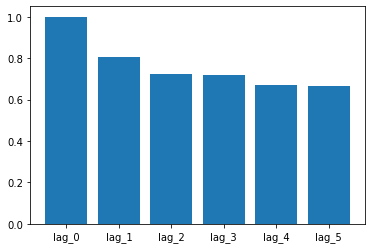

In [44]:
list(df.corr()['lag_0'].index)
plt.bar(list(df.corr()['lag_0'].index), list(df.corr()['lag_0']));

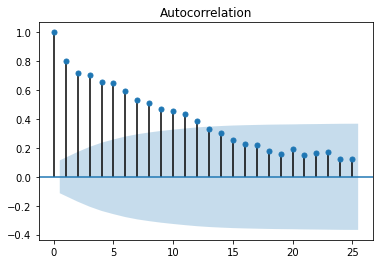

In [45]:
# Original data

plot_acf(train);

The above autocorrelation shows that there is correlation between lags up to about 12 weeks back.  

When Looking at the ACF graph for the original data, we see a strong persistent correlation with higher order lags. This is evidence that we should take a **first difference** of the data to remove this autocorrelation.

This makes sense, since we are trying to capture the effect of recent lags in our ARMA models, and with high correlation between distant lags, our models will not come close to the true process.

Generally, we use an ACF to predict MA terms.
Moving Average models are using the error terms of the predictions to calculate the next value.  This means that the algorithm does not incorporate the direct effect of the previous value. It models what are sometimes called **impulses** or **shocks** whose effect accounts for the propogation of correlation from one lag to the other. 

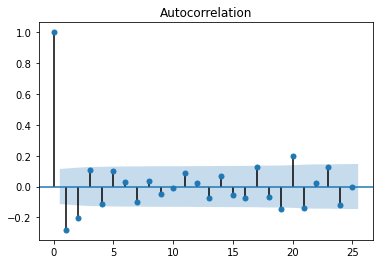

In [46]:
plot_acf(train.diff().dropna());

This autocorrelation plot can now be used to get an idea of a potential MA term.  Our differenced series shows negative significant correlation at a lag of 1, which suggests adding 1 MA term. There is also a statistically significant 2nd term, so adding another MA is another possibility.


> If the ACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag at which the ACF cuts off is the indicated number of MA terms. [Duke](https://people.duke.edu/~rnau/411arim3.htm#signatures)

Rule of thumb:
    
  - If the autocorrelation shows negative correlation at the first lag, try adding MA terms.
    
    

![alt text](../img/armaguidelines.png)

The plots above suggest that we should try a 1st order differenced MA(1) or MA(2) model on our weekly gun offense data.

This aligns with our AIC scores from above.

The ACF can be used to identify the possible structure of time series data. That can be tricky going forward as there often isn’t a single clear-cut interpretation of a sample autocorrelation function.

Let's plot our training predictions, using an ARIMA model with order (1, 1, 2).

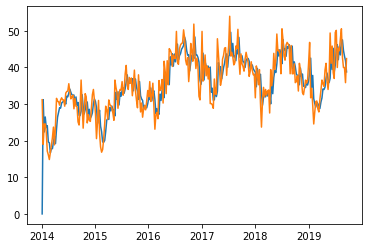

In [47]:
aa_model = ARIMA(train, order=(1, 1, 2)).fit()
y_hat_train = aa_model.predict(typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_train)
ax.plot(train);

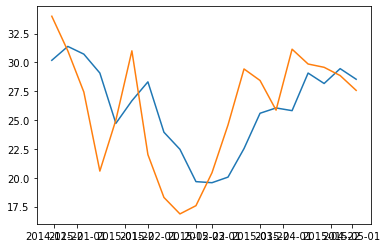

In [48]:
# Let's zoom in:

fig, ax = plt.subplots()
ax.plot(y_hat_train[50:70])
ax.plot(train[50:70]);

In [65]:
aa_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  298
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -853.009
Date:                Thu, 08 Apr 2021   AIC                           1714.019
Time:                        16:14:58   BIC                           1728.794
Sample:                    01-05-2014   HQIC                          1719.934
                         - 09-15-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4760      0.169     -2.816      0.005      -0.807      -0.145
ma.L1          0.0678      0.160      0.425      0.671      -0.245       0.380
ma.L2         -0.4418      0.081     -5.436      0.000      -0.601      -0.283
sigma2        18.2629      1.370     13.329      0.000      15.577      20.948
===================================================================================
Ljung-Box (Q):                       55.85   Jarque-Bera (JB):                 5.12
Prob(Q):                              0.05   Prob(JB):                         0.08
Heteroskedasticity (H):               1.39   Skew:                             0.24
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Testing

Now that we have chosen our parameters, let's try our model on the test set.

In [66]:
test

2019-09-22    40.857143
2019-09-29    35.142857
2019-10-06    31.571429
2019-10-13    35.142857
2019-10-20    37.714286
                ...    
2021-01-17    42.857143
2021-01-24    45.857143
2021-01-31    35.714286
2021-02-07    36.285714
2021-02-14    32.750000
Freq: W-SUN, Length: 74, dtype: float64

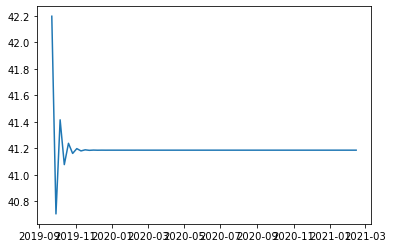

In [67]:
y_hat_test = aa_model.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_test);

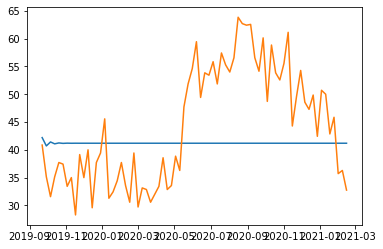

In [68]:
fig, ax = plt.subplots()
ax.plot(y_hat_test)
ax.plot(test);

In [69]:
np.sqrt(mean_squared_error(test, y_hat_test))

10.815604063199014

Our predictions on the test set certainly leave something to be desired.  

Let's take another look at our autocorrelation function of the original series.

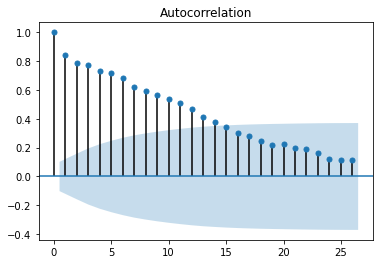

In [70]:
plot_acf(ts_weekly);

Let's increase the lags

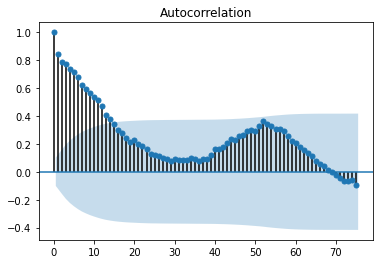

In [71]:
plot_acf(ts_weekly, lags=75);

There seems to be a wave of correlation at around 50 lags.
What is going on?

## SARIMA

Looks like we may have some other forms of seasonality.  Luckily, we have SARIMA, which stands for Seasonal Auto Regressive Integrated Moving Average.  That is a lot.  The `statsmodels` package is actually called SARIMAX.  The X stands for exogenous, and we are only dealing with endogenous variables, but we can use this class.

A seasonal ARIMA model is classified as an **ARIMA(p,d,q)x(P,D,Q)** model, 

    **p** = number of autoregressive (AR) terms 
    **d** = number of differences 
    **q** = number of moving average (MA) terms
     
    **P** = number of seasonal autoregressive (SAR) terms 
    **D** = number of seasonal differences 
    **Q** = number of seasonal moving average (SMA) terms

In [50]:
train.index

DatetimeIndex(['2014-01-05', '2014-01-12', '2014-01-19', '2014-01-26',
               '2014-02-02', '2014-02-09', '2014-02-16', '2014-02-23',
               '2014-03-02', '2014-03-09',
               ...
               '2019-07-14', '2019-07-21', '2019-07-28', '2019-08-04',
               '2019-08-11', '2019-08-18', '2019-08-25', '2019-09-01',
               '2019-09-08', '2019-09-15'],
              dtype='datetime64[ns]', length=298, freq='W-SUN')

In [72]:
p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 52)
SARIMAX: (0, 1, 0) x (0, 1, 1, 52)
SARIMAX: (0, 1, 0) x (1, 1, 0, 52)
SARIMAX: (0, 1, 0) x (1, 1, 1, 52)
SARIMAX: (0, 1, 1) x (0, 1, 0, 52)
SARIMAX: (0, 1, 1) x (0, 1, 1, 52)
SARIMAX: (0, 1, 1) x (1, 1, 0, 52)
SARIMAX: (0, 1, 1) x (1, 1, 1, 52)
SARIMAX: (1, 1, 0) x (0, 1, 0, 52)
SARIMAX: (1, 1, 0) x (0, 1, 1, 52)
SARIMAX: (1, 1, 0) x (1, 1, 0, 52)
SARIMAX: (1, 1, 0) x (1, 1, 1, 52)
SARIMAX: (1, 1, 1) x (0, 1, 0, 52)
SARIMAX: (1, 1, 1) x (0, 1, 1, 52)
SARIMAX: (1, 1, 1) x (1, 1, 0, 52)
SARIMAX: (1, 1, 1) x (1, 1, 1, 52)


In [73]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(train,
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('Oops!')
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 52) - AIC:1576.8788291493852
ARIMA(0, 1, 0)x(0, 1, 1, 52) - AIC:1204.4985892672105
ARIMA(0, 1, 0)x(1, 1, 0, 52) - AIC:1225.469705290866
ARIMA(0, 1, 0)x(1, 1, 1, 52) - AIC:1207.6699611363529
ARIMA(0, 1, 1)x(0, 1, 0, 52) - AIC:1481.7587656854207
ARIMA(0, 1, 1)x(0, 1, 1, 52) - AIC:1129.1627382653662
ARIMA(0, 1, 1)x(1, 1, 0, 52) - AIC:1160.7640473650135
ARIMA(0, 1, 1)x(1, 1, 1, 52) - AIC:1134.7342390437075
ARIMA(1, 1, 0)x(0, 1, 0, 52) - AIC:1535.569792707883
ARIMA(1, 1, 0)x(0, 1, 1, 52) - AIC:1180.5485531145398
ARIMA(1, 1, 0)x(1, 1, 0, 52) - AIC:1189.3533353015098
ARIMA(1, 1, 0)x(1, 1, 1, 52) - AIC:1182.9655873270433
ARIMA(1, 1, 1)x(0, 1, 0, 52) - AIC:1476.6008134790818
ARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:1124.414882278214
ARIMA(1, 1, 1)x(1, 1, 0, 52) - AIC:1144.5347878581042
ARIMA(1, 1, 1)x(1, 1, 1, 52) - AIC:1129.8052126359303


Let's try the third from the bottom, ARIMA(1, 1, 1)x(0, 1, 1, 52).

In [74]:
sari_mod =SARIMAX(train,
                  order=(1, 1, 1),
                  seasonal_order=(0, 1, 1, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

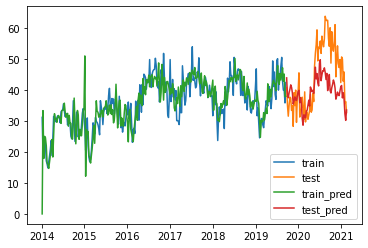

In [75]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

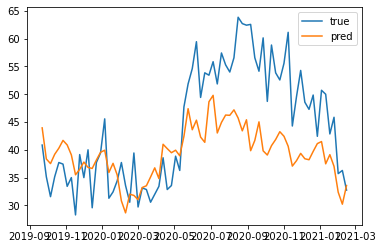

In [76]:
# Let's zoom in on test
fig, ax = plt.subplots()

ax.plot(test, label='true')
ax.plot(y_hat_test, label='pred')

plt.legend();

In [77]:
np.sqrt(mean_squared_error(test, y_hat_test))

9.233681879776956

## Forecast

Lastly, let's predict into the future.

To do so, we'll refit to our entire training set.

In [78]:
sari_mod =SARIMAX(ts_weekly,
                  order=(1, 1, 1),
                  seasonal_order=(0, 1, 1, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [79]:
forecast = sari_mod.forecast(steps=52)

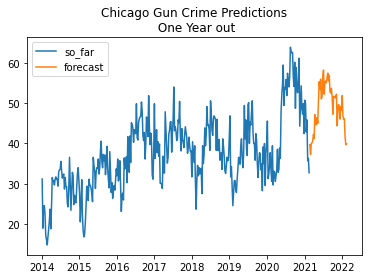

In [80]:
fig, ax = plt.subplots()

ax.plot(ts_weekly, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Chicago Gun Crime Predictions\n One Year out')

plt.legend();

In [82]:
p = q = range(2, 4)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (2, 1, 2) x (2, 1, 2, 52)
SARIMAX: (2, 1, 2) x (2, 1, 3, 52)
SARIMAX: (2, 1, 2) x (3, 1, 2, 52)
SARIMAX: (2, 1, 2) x (3, 1, 3, 52)
SARIMAX: (2, 1, 3) x (2, 1, 2, 52)
SARIMAX: (2, 1, 3) x (2, 1, 3, 52)
SARIMAX: (2, 1, 3) x (3, 1, 2, 52)
SARIMAX: (2, 1, 3) x (3, 1, 3, 52)
SARIMAX: (3, 1, 2) x (2, 1, 2, 52)
SARIMAX: (3, 1, 2) x (2, 1, 3, 52)
SARIMAX: (3, 1, 2) x (3, 1, 2, 52)
SARIMAX: (3, 1, 2) x (3, 1, 3, 52)
SARIMAX: (3, 1, 3) x (2, 1, 2, 52)
SARIMAX: (3, 1, 3) x (2, 1, 3, 52)
SARIMAX: (3, 1, 3) x (3, 1, 2, 52)
SARIMAX: (3, 1, 3) x (3, 1, 3, 52)


In [83]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(train,
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('Oops!')
            continue

ARIMA(2, 1, 2)x(2, 1, 2, 52) - AIC:806.0734336802584
ARIMA(2, 1, 2)x(2, 1, 3, 52) - AIC:495.9680878734522


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(2, 1, 2)x(3, 1, 2, 52) - AIC:499.7125180395778


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(2, 1, 2)x(3, 1, 3, 52) - AIC:497.1157954037393
ARIMA(2, 1, 3)x(2, 1, 2, 52) - AIC:802.053794662827
ARIMA(2, 1, 3)x(2, 1, 3, 52) - AIC:491.47758155934565


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(2, 1, 3)x(3, 1, 2, 52) - AIC:501.0231970981144


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(2, 1, 3)x(3, 1, 3, 52) - AIC:495.0260145346355
ARIMA(3, 1, 2)x(2, 1, 2, 52) - AIC:807.7399772726578
ARIMA(3, 1, 2)x(2, 1, 3, 52) - AIC:497.4393513802864


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(3, 1, 2)x(3, 1, 2, 52) - AIC:497.3339850803397


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(3, 1, 2)x(3, 1, 3, 52) - AIC:498.3531760715719


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(3, 1, 3)x(2, 1, 2, 52) - AIC:796.1178574603125


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(3, 1, 3)x(2, 1, 3, 52) - AIC:490.343401187196


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(3, 1, 3)x(3, 1, 2, 52) - AIC:499.6976077677671


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(3, 1, 3)x(3, 1, 3, 52) - AIC:495.73085504311655


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


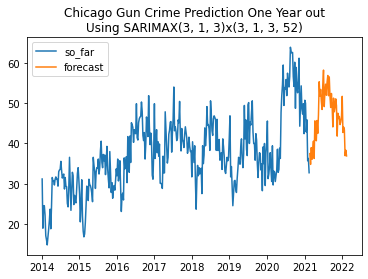

In [85]:
sari_mod =SARIMAX(ts_weekly,
                  order=(3, 1, 3),
                  seasonal_order=(3, 1, 3, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
forecast = sari_mod.forecast(steps=52)
fig, ax = plt.subplots()

ax.plot(ts_weekly, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title(f'Chicago Gun Crime Prediction One Year out\nUsing SARIMAX(3, 1, 3)x(3, 1, 3, 52)')

plt.legend();

In [ ]:
p = q = range(4, 6)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))